# Set Ups

In [16]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from pkg_resources import ContextualVersionConflict

# from rich.console import Console

import requests
import json

import time
from sqlalchemy import delete
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [3]:
# connet to graphql
sample_transport=RequestsHTTPTransport(
    url='http://localhost:4001/graphql',
    use_json=True,
    headers={
        "Content-type": "application/json",
    },
    verify=False
)

client = Client(
    #execute_timeout=20,
    transport=sample_transport,
    fetch_schema_from_transport=True,
)

session = requests.Session()
session.auth = ('admin', "secret")

#hostname = 'http://ec2-3-64-237-95.eu-central-1.compute.amazonaws.com:8080/tilt/tilt'
#auth = session.post(hostname)
#response = json.loads(session.get(hostname).content)

#tilt = json.loads(requests.get('http://ec2-3-64-237-95.eu-central-1.compute.amazonaws.com:8080/tilt/tilt').content)
#print("Fetch Successful!", response)


json_file = open('/Users/johannes/Desktop/TU/playground/tilt')
tilt = json.load(json_file)

In [4]:
hostname = 'http://ec2-3-64-237-95.eu-central-1.compute.amazonaws.com:8080/tilt/tilt'
auth = session.post(hostname)
response = session.get(hostname).content
json_tilt = json.loads(response)

# Load Data from TILT HUB into NEO4J

In [4]:

def create_node(parent):

    """
    func:   create_node
            Recursively goes through JSON and builds a mutation to generate the neo4j graph
            Base case is when an entry is a string
    """

    def rem_dq(uncleaned):

        """
        func:   rem_dq
                removes double quotes. 
                Needed to avoid errors in upload
        """
        if isinstance(uncleaned,str):
            return re.sub('"', '', uncleaned)
        else:
            return uncleaned

    #mutation string
    label_string = ""

    #iterate through elements of dictionary or list
    for i, key in enumerate(parent):

        #if key == 'rightToRectificationOrDeletion':
            #label_string += " HERE "
            
        try:
            if key[0] == "$": # the dollar sign infront of the $oid is not recognised so we have to remove it
                label_string += f'{key[1:]}: "{rem_dq(parent[key])}"'


            # if key is a list
            elif isinstance(parent[key], list):

            
                #if list item is empty
                if len(parent[key]) == 0:
                    
                    #label_string += f'{key}: "{parent[key]}"'
                    label_string += "" # just add nothing. not ideal as we lose out on recording missing information but easier to fix than trying to fix missfilled fields in tilt

                #two types of entries: nodes or strings
                else:

                    # When we get lists with multiple same node entries, we make a list of nodes. 
                    # There we can only need one create statement and then close it afterwards
                    label_string += key+ ':{create:['
                    node_list = True

                    for list_item in parent[key]:
                        
                        # some entries are a string wrapped in a lists instead of a node.
                        if type(list_item) == type(""): 
                            #deleted = label_string[-len(f'{key}:{{create:['):]
                            label_string = label_string[:-len(f'{key}:{{create:[')]                             
                            label_string += f'{key}: "{rem_dq(list_item)}"'
                            node_list = False

                        # if the list items are dictionaries make a new node
                        else: 
                            label_string += f'{{{create_node(list_item)}}},'

                    #
                    if node_list:
                        label_string = label_string[:-1]+']}'
            
                
            # if the element is a dictionary
            elif isinstance(parent[key], dict): 
                
                #create the next node for this dict
                label_string += f'{key}:{{create:[{{{create_node(parent[key])}}}]}}'

            else: # base case
                
                if i < len(parent)-1:

                    label_string += f'{key}: "{rem_dq(parent[key])}", '
                    
                else:
                    label_string += f'{key}: "{rem_dq(parent[key])}"'
                
        except Exception as ex:
            label_string += "BIG ERROR HERE"  
            print(ex)  

    #certain characters (like tilda) are rejected by gql
    label_string = re.sub('~', "", label_string)
    label_string = label_string.strip().replace('\n', "")
    
    return label_string

    

In [57]:
#print("mutation { createtilts( input: [ { " + create_node(json_tilt[5]) + "}] ) {tilts {meta { name } } }}")

In [6]:
tilt_mutations = []
for tilt_entry in tqdm(tilt):
    tilt_entry  
    tilt_mutations.append("mutation { createtilts( input: [ { " + create_node(tilt_entry) + "}] ) {tilts {meta { name } } }}")

100%|██████████| 73/73 [00:00<00:00, 1677.51it/s]


In [7]:
successes = 0
for i, query_string in enumerate(tqdm(tilt_mutations)):
    #print("Query String: ", query_string)
    try:
        query = gql(query_string)
        client.execute(query)
        successes += 1
    except Exception as syn:
        print(syn)
        print("Error With Tilt No.", i)

print("Successfully Uploaded:", 100*(successes/(i+1)), "per. of tilts")

100%|██████████| 73/73 [05:15<00:00,  4.32s/it]

Successfully Uploaded: 100.0 per. of tilts


# Analysis 

In [5]:
from neo4j import GraphDatabase

In [58]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [6]:
class make_queries:

    """
    class:  exampleTilt
    input:  - uri: bolt uri from neo4j
            - auth: credentials for neo4j
            - no_nodes: number of nodes to create 
            - comp_df:  dataframe with company names and websites
            - mu_poisson_*: average no. of samples for poisson distribution
            - reset: whether to delete all nodes in database (default False, meant for experimentation)

    """

    def __init__(self, uri, auth,  reset = False):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.reset = reset


    def close(self):
        self.driver.close()
        
    # Match and display all friendships.
    @classmethod
    def print_friendships(cls, tx):
        result = tx.run("MATCH (a)-[:KNOWS]->(b) RETURN a.name, b.name")
        for record in result:
            print("{} knows {}".format(record["a.name"], record["b.name"]))

    @classmethod
    def delete_nodes(cls, tx):
        tx.run("MATCH (n) detach delete n")

    
    def get_sorensen(self, tx, threshold = .9):
        tx.run("MATCH (m:meta), (r:recipient) "
                f"WHERE apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name), 'en') > {threshold} "
                "MERGE (m)-[c:has_sorensen]->(r)")


    def run_query(self, tx, cyper_statement):
        
        result = tx.run(cyper_statement)
        return [point.data() for point in result] 
        

    def main(self):
        saved_bookmarks = []  # To collect the session bookmarks

        if self.reset:
            assurance = input("WARNING DELETING ALL DATA FROM THE GRAPH, TO CONTINUE WRITE 'yes'")
            if assurance == 'yes':
                with self.driver.session() as session_del:
                    session_del.write_transaction(self.delete_nodes)
                    saved_bookmarks.append(session_del.last_bookmark())

        #with self.driver.session() as session_sorensen: 
        #    session_sorensen.write_transaction(self.get_sorensen)

infos = make_queries(uri = 'bolt://localhost:7687', 
                    auth = ('neo4j', 'letmein'), 
                    reset=False)

In [51]:
dict_of_categories = [{'category':i['d.category'],'name':i['m.name']} for i in infos.driver.session().write_transaction(infos.run_query, "match (m:meta)-[]-(t:tilt)-[]->(d:dataDisclosed) return m.name, d.category")]# if i['d.category'] != None ]

list_of_categories = [i['category'] for i in dict_of_categories  if i['category'] != None ]

with open('categories_tilt', 'wb') as fp:
    pickle.dump(np.unique(np.asarray(list_of_categories)), fp)

In [64]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [107]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)

Text(0.5, 0, 'No. of categories')

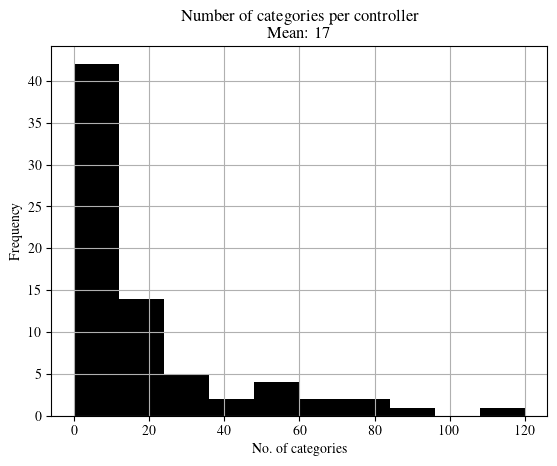

In [118]:
grouped_by_name_df = pd.DataFrame(dict_of_categories).groupby('name').count()
plt.grid()
plt.hist(grouped_by_name_df['category'], color = 'black')
plt.style.use('seaborn-pastel')

plt.title(f"Number of categories per controller \n Mean: {round(grouped_by_name_df['category'].sum()/73)}")
plt.ylabel("Frequency")
plt.xlabel("No. of categories")

In [109]:
dict_of_purposes = [{'purpose':i['p.purpose'],'name': i['m.name']} for i in infos.driver.session().write_transaction(infos.run_query, "match (m:meta)-[]-(t:tilt)-[]->(d:dataDisclosed)-[]-(p:purposes) return p.purpose, m.name")]# if i['p.purpose'] != None ]

list_of_purposes =  [i['purpose'] for i in dict_of_purposes if i['purpose'] != None]

with open('purpose_tilt', 'wb') as fp:
    pickle.dump(np.unique(np.asarray(list_of_purposes)), fp)

Text(0.5, 0, 'No. purposes')

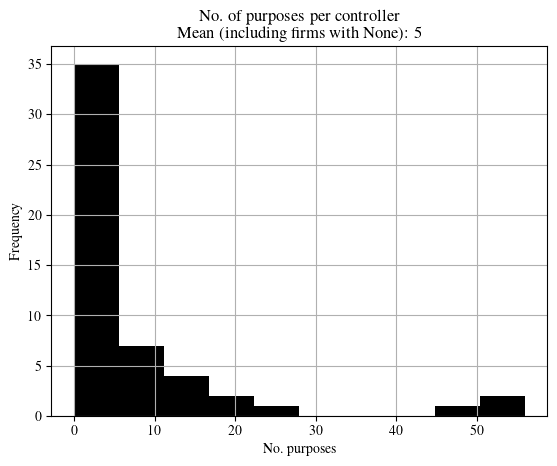

In [119]:
pd_purposes = pd.DataFrame(dict_of_purposes).groupby('name').count()
plt.grid()
plt.hist(pd_purposes['purpose'], color= 'black')
plt.title(f"No. of purposes per controller \n Mean (including firms with None): {round(pd_purposes['purpose'].sum()/73)}")
plt.ylabel('Frequency')
plt.xlabel("No. purposes")

In [55]:
pd_purposes.head()

,purpose
name,
ARD Mediathek,6
Amazon Alexa Terms of Use,4
Apple,2
Bundestag.de,14
CDU,0


In [56]:
pd.DataFrame(dict_of_purposes)

,purpose,name
0,None,fresenius medical care
1,None,fresenius medical care
2,None,fresenius medical care
3,None,fresenius medical care
4,None,fresenius medical care
...,...,...
1337,None,enel
1338,None,enel
1339,None,enel
1340,None,enel
